In [ ]:
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import sys
import re
import tensorflow as tf
import json
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from string import punctuation
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import TaggedDocument
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Pull BART embedding data 

In [ ]:
# Data resaved to local Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget "https://raw.githubusercontent.com/255-DataMining/termproject/main/bart_doc_embeddings.zip?token=AEVQ7D44HLZW77XOZDW4R7C7VTX54" -O bart_doc_embeddings.zip

!unzip /content/drive/My\ Drive/bart_doc_embeddings.zip

Archive:  /content/drive/My Drive/bart_doc_embeddings.zip
  inflating: bart_doc_embeddings     


In [ ]:
import pandas as pd
embeddings_df = pd.read_pickle('bart_doc_embeddings')

In [ ]:
target = embeddings_df['Target']
del embeddings_df['Target'] # remove target column from dataframe

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings_df, target, test_size = 0.2, shuffle=True)

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(df['Text'].values))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

NameError: ignored

In [ ]:
X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
45440,-0.134450,0.262440,0.578321,-1.077683,-0.356566,-0.501722,-0.522065,0.074667,-0.342787,0.252209,0.388035,-0.199644,-0.136609,-0.501038,0.820075,0.135116,0.666309,-0.363225,0.178121,0.273393,4.074825,0.026011,0.690269,-0.110360,0.108706,-0.495936,-0.511397,-0.029927,0.072510,0.940371,-0.467790,-0.711587,-0.099095,-0.158908,-0.463326,-0.402371,-0.844128,0.116822,-0.297042,-0.266423,...,-0.780134,-0.047374,0.420634,-0.244636,-0.423883,-0.154868,-0.390107,-0.010902,-0.761026,-0.121108,-0.484754,-0.751321,0.060033,-0.494115,0.773746,0.223569,-0.070448,-0.273847,0.146313,-0.001090,0.336629,-0.417566,-0.294803,-0.681473,0.463959,-0.396953,0.078303,-3.402322,0.006979,-0.481918,-0.483600,-0.137464,0.070677,1.301823,-0.478286,-0.343352,0.431994,-0.028658,0.590625,-0.374684
4682,-0.071097,0.650376,0.105896,-0.975207,-0.227172,-0.302817,-0.705155,0.258375,-0.335785,0.031485,-0.264432,0.262880,-0.383808,0.042080,0.222424,-0.035038,0.220420,-0.274977,0.569885,0.446317,4.058769,0.173747,0.219695,-0.410815,-0.396934,-0.631219,-0.561822,-0.339196,-0.010965,0.202776,0.039486,-0.572300,0.457579,0.198336,-0.373248,-0.141867,-0.835898,-0.313361,-0.328249,-0.388132,...,-0.322029,0.069437,0.592489,-0.126234,-0.179142,-0.207534,-0.549950,0.209278,-0.324933,-0.096700,-0.744409,-0.681939,-0.075660,-0.288228,0.473865,-0.125110,-0.095247,-0.163965,-0.066139,0.214853,0.085618,-0.242203,-0.416534,-0.659860,0.062063,0.124640,0.384943,-4.263932,0.250174,-0.185871,-0.637177,-0.480210,0.340123,1.285411,-1.049078,-0.914834,-0.563537,-0.244260,0.535899,-0.951509
2552,-0.064202,0.351255,0.179642,-1.092753,-0.236207,-0.495307,-0.545382,-0.010428,-0.380019,0.084189,-0.050136,-0.247001,-0.074742,0.162428,0.268178,-0.453305,0.268456,0.071911,0.705507,0.600100,4.130463,0.581900,0.286419,-0.500350,-0.293510,-0.416525,-0.898593,-0.500154,0.379782,0.158139,0.100749,-0.897189,-0.116459,0.398995,-0.438727,-0.250573,-0.764475,-0.107354,-0.310506,-0.122787,...,0.178988,-0.348918,0.267478,-0.269511,-0.260660,-0.230779,-0.776124,0.063705,-0.328794,-0.144679,-0.516167,-0.499578,0.296119,-0.429111,0.460954,0.361915,-0.130458,0.148237,-0.178780,0.204167,-0.037812,-0.013201,-0.528037,-0.839780,0.506832,0.184121,0.298673,-4.292791,0.164138,-0.424425,-0.470607,-0.148486,0.304992,1.216745,-0.588296,-0.647081,-0.425242,0.033832,0.289780,-0.789723
63405,-0.069562,1.002866,0.472012,-1.147172,-0.106377,-0.280113,-0.404112,-0.337914,-0.309353,0.583253,0.308521,-0.060384,-0.242463,-0.262891,0.513804,0.059984,0.232748,0.122221,0.624330,0.596456,3.907214,0.148736,0.180884,-0.312983,-0.057843,-0.637491,-0.779275,-0.519098,-0.294131,0.137462,-0.237275,-0.626726,-0.082022,0.163667,-0.268591,-0.673653,-0.827068,-0.235209,0.053536,-0.013168,...,0.074356,-0.003652,0.584716,-0.057593,-0.464828,-0.331034,-0.325581,0.320217,-0.446186,-0.187984,0.147887,-0.547328,0.113338,-0.167756,0.649093,-0.006725,0.233883,-0.156380,-0.011423,0.348039,-0.563998,-0.224916,-0.278807,-0.451333,0.388905,0.556542,0.534480,-4.942526,-0.215233,-0.296609,-0.470443,-0.296959,0.192390,1.367222,-0.556850,-0.315990,-0.033124,0.214176,0.462258,-0.015277
62660,0.369185,0.699991,-0.121170,-0.544654,-0.107379,-0.636448,-0.379480,-0.090207,-0.646012,0.069929,-0.590505,-0.025946,0.164470,0.055385,0.486047,-0.036013,0.192093,-0.168957,0.575531,0.047989,3.662821,0.261048,0.733527,-0.237862,-0.313786,-0.180522,-0.227655,-0.684802,0.006642,0.707173,0.636501,-0.747069,-0.200026,0.568793,-0.561503,-0.440175,-0.774842,-0.467958,-0.147768,-0.316719,...,-0.279264,-0.008654,0.760246,-0.149547,-0.125908,-0.368738,-0.346827,-0.248078,-0.254094,0.010780,-0.532663,-0.951509,-0.218478,-0.674714,0.850886,0.417761,-0.469728,0.055989,0.011159,0.222580

## Model creation below using Keras library

In [ ]:
# Define needed variables
embed_size = 200
maxlen = 2000
# Importing needed keras libraries
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU 
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPool1D, concatenate
from keras.models import Model
import keras
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

### NN model with BART embeddings

In [ ]:
# Trying sequential model
model = Sequential()

model.add(layers.InputLayer(input_shape=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(layers.BatchNormalization()) # Batch normalization
model.add(Dense(64, activation='relu'))
model.add(layers.BatchNormalization()) # Batch normalization
model.add(Dense(64, activation='relu'))
model.add(layers.BatchNormalization()) # Batch normalization
model.add(Dense(64, activation='relu'))
model.add(layers.BatchNormalization()) # Batch normalization
model.add(Dense(64, activation='relu'))
model.add(layers.BatchNormalization()) # Batch normalization
model.add(Dense(64, activation='relu')) # 4 dense layers
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss ="binary_crossentropy", optimizer='adam', metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

# Credit to: https://realpython.com/python-keras-text-classification/

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

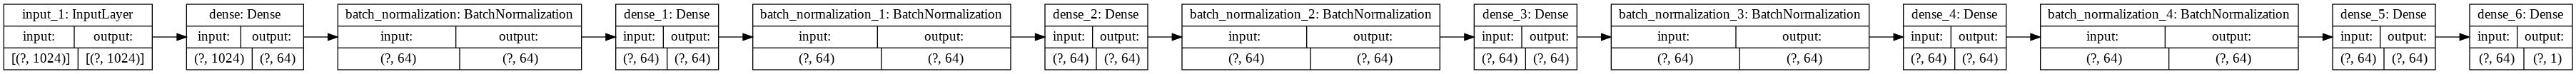

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')

### Train the model for 25 epochs

In [ ]:
model.fit(X_train, y_train, batch_size = 64, epochs = 25, validation_split=0.1)

Epoch 1/25
1012/1012 [==============================] - 5s 5ms/step - loss: 0.1818 - accuracy: 0.9253 - precision_6: 0.9214 - recall_6: 0.9260 - val_loss: 0.1864 - val_accuracy: 0.9178 - val_precision_6: 0.8625 - val_recall_6: 0.9898
Epoch 2/25
1012/1012 [==============================] - 5s 5ms/step - loss: 0.1232 - accuracy: 0.9524 - precision_6: 0.9471 - recall_6: 0.9559 - val_loss: 0.1066 - val_accuracy: 0.9588 - val_precision_6: 0.9621 - val_recall_6: 0.9534
Epoch 3/25
1012/1012 [==============================] - 5s 5ms/step - loss: 0.1064 - accuracy: 0.9591 - precision_6: 0.9552 - recall_6: 0.9613 - val_loss: 0.1074 - val_accuracy: 0.9569 - val_precision_6: 0.9583 - val_recall_6: 0.9534
Epoch 4/25
1012/1012 [==============================] - 4s 4ms/step - loss: 0.0978 - accuracy: 0.9627 - precision_6: 0.9598 - recall_6: 0.9639 - val_loss: 0.1197 - val_accuracy: 0.9518 - val_precision_6: 0.9573 - val_recall_6: 0.9434
Epoch 5/25
1012/1012 [==============================] - 4s 4ms/s

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Precision:  {:.4f}".format(precision))
print("Training Recall:  {:.4f}".format(recall))

loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Precision:  {:.4f}".format(precision))
print("Testing Recall:  {:.4f}".format(recall))

Training Accuracy: 0.9931
Training Precision:  0.9890
Training Recall:  0.9969
Testing Accuracy:  0.9711
Testing Precision:  0.9624
Testing Recall:  0.9792


In [ ]:
model.save("NN_model_embeddings_final.h5")

In [ ]:
import numpy as np
import seaborn as sns
F1_Score_Test = 2 *( ( precision * recall) / (precision + recall))

metrics_array = np.array([[accuracy, precision], [recall, F1_Score_Test]])

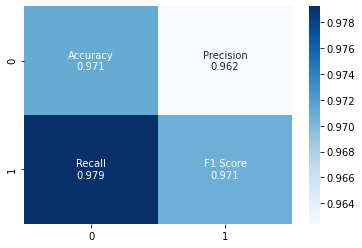

In [ ]:
group_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
group_counts = ["{0:0.3f}".format(value) for value in metrics_array.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(metrics_array, annot=labels, fmt='', cmap="Blues")

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Save model locally
#model_save_name = 'NN_model_Keras_Embedding_layer'
#path = F"/content/gdrive/My Drive/{model_save_name}" 
#model.save(path)

INFO : Assets written to: /content/gdrive/My Drive/NN_model_Keras_Embedding_layer/assets


## New model but with no embeddings

In [ ]:
import pandas as pd
# Pulling data from Hussein's github repo
!wget "https://raw.githubusercontent.com/HAadams/fake_news_dataset/master/combined_data.zip" -O combined_data.zip
!unzip combined_data.zip

--2020-11-20 22:49:11--  https://raw.githubusercontent.com/HAadams/fake_news_dataset/master/combined_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71497977 (68M) [application/zip]
Saving to: ‘combined_data.zip’

combined_data.zip   100%[===================>]  68.19M   114MB/s    in 0.6s    

2020-11-20 22:49:12 (114 MB/s) - ‘combined_data.zip’ saved [71497977/71497977]

Archive:  combined_data.zip
  inflating: combined_data.csv       


In [ ]:
df = pd.read_csv('combined_data.csv')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = df['Text']
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# encode document
vector = vectorizer.transform(text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
text = df['Text']
vectorizer = TfidfVectorizer()
tf_vector = vectorizer.fit_transform(text)

In [ ]:
text = df['Text'].tolist()
y = df['Target'].tolist()
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_vector, y, test_size = 0.2, shuffle=True)

In [ ]:
X_test.shape

(17980, 221412)

In [ ]:
X_train.shape

(71918, 221412)

In [ ]:
del model
model = Sequential()
max_features = 230000 

model.add(layers.Dense(2, activation='relu', input_shape=(X_train.shape[1],) ) )
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(.4))
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(.4))
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(.4))
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(.4))
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(.4))
model.add(Dense(64, activation='relu')) # 4 dense layers
model.add(layers.Dropout(.4))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss ="binary_crossentropy", optimizer='adam', metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 442826    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [ ]:
import numpy as np
# Due to large feature space, each document must be individually trained for model
for item in range(X_train.shape[0]):
  model.fit(X_train[item].toarray(), np.array([y_train[item]]), epochs = 20, verbose=0)

In [ ]:
# Predict function gives continuous numerical output
y_pred = []
for item in range(X_test.shape[0]):
    y_pred.append(model.predict(X_test[item].toarray(), verbose=0))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Map continuous output to binary values
newList = [item.tolist()[0][0] for item in np.array(y_pred)]
y_pred = np.asarray(newList)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

wo_embed_nn_acc = accuracy_score(y_test, y_pred)
wo_embed_nn_prec = precision_score(y_test, y_pred, average='macro')
wo_embed_nn_recall = recall_score(y_test, y_pred, average='macro')
print('Accuracy:\t', wo_embed_nn_acc)
print('Precision:\t', wo_embed_nn_prec)
print('Recall:\t\t', wo_embed_nn_recall)

In [ ]:
model.save("NN_model_no_embeddings_final.h5")